<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Model-agnostic Explanations**


In this lab, we will first train a random forest model to predict if employees are looking for a job change, then we want to interpret the trained model in order to understand how exactly it makes predictions. Since random forest model is normally very complex to understand, we will just treat it as a black-box model first. Then, you will have the practice opportunities to apply various model-agnostic explanation methods to explain the black-box model.


## Objectives

After completing this lab you will be able to:

* Calculate Permutation Feature Importance
* Use Partial Dependency Plot to illustrate relationships between feature and outcomes
* Build Global Surrogate Models
* Build Local Surrogate Models using `LIME`


----


## Setup


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lime.lime_tabular

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz, plot_tree
from sklearn.inspection import permutation_importance, partial_dependence, PartialDependenceDisplay
from sklearn.metrics import roc_auc_score

Data loading

In [7]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/hr_new_job_processed.csv"
job_df = pd.read_csv(url)

In [8]:
job_df.head()

,city_development_index,training_hours,company_size,experience,education_level,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,target
0,0.698000,43.000000,2.0,10.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.624000,204.000000,4.0,11.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.815687,14.317001,3.0,15.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.903874,18.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.624000,111.000000,0.0,7.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [9]:
job_df.columns

Index(['city_development_index', 'training_hours', 'company_size',
       'experience', 'education_level', 'company_type_Early Stage Startup',
       'company_type_Funded Startup', 'company_type_NGO', 'company_type_Other',
       'company_type_Public Sector', 'company_type_Pvt Ltd', 'target'],
      dtype='object')

In [10]:
job_df.dtypes

city_development_index              float64
training_hours                      float64
company_size                        float64
experience                          float64
education_level                     float64
company_type_Early Stage Startup    float64
company_type_Funded Startup         float64
company_type_NGO                    float64
company_type_Other                  float64
company_type_Public Sector          float64
company_type_Pvt Ltd                float64
target                              float64
dtype: object

In [11]:
job_df.describe()

,city_development_index,training_hours,company_size,experience,education_level,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,target
count,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000
mean,0.806056,64.380421,2.748997,9.530985,2.131568,0.029180,0.042537,0.023619,0.005557,0.045442,0.853665,0.500000
std,0.128302,59.048600,1.783676,6.733267,0.627610,0.161802,0.197495,0.147348,0.070875,0.200717,0.342167,0.500022
min,0.448000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.682000,23.000000,2.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.878000,46.000000,2.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000
75%,0.920000,88.000000,3.000000,15.000000,2.247823,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,0.949000,336.000000,7.000000,21.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The dataset contains the following features (predictors):

- `city_ development index` : Developement index of the city, ranged from 0 to 1
- `training_hours`: Training hours completed, ranged from 0 to 336
- `company_size`: Size of the current company, ranged from 0 to 7 where 0 means less than 10 employees and 7 means more than 10,000 employees
- `education_level`: Education level of the candidate, ranged from 0 to 4 where 0 means Primary School and 4 means Phd
- `experience`: Total experience in years, ranged from 0 to 21
- `company_type` : _Categorical column_ with one-hot encodings. Type of current company:  'Pvt Ltd', 'Funded Startup', 'Early Stage Startup', 'Other', 'Public Sector', 'NGO'

and the prediction outcome is:
- `target`: `0` – Not looking for a job change, `1` – Looking for a job change


## Build a Random Forest Classifier as the Black Box Model

### Train test split

In [12]:
Y_COLUMN = 'target'

In [13]:
FEATURE_COLUMNS = [colname for colname in job_df.columns if colname != Y_COLUMN]

In [14]:
X = job_df[FEATURE_COLUMNS]
y = job_df[Y_COLUMN]
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (11504, 11), y shape: (11504,)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=12)

Now let's train a `Random Forest` model with the following preset arguments. If you like, you may also use hyperparameter tuning methods to tune these parameters yourself.
- `random_state = 0` as a random seed to reproduce the result
- `max_depth = 25` means the max depth of a tree should be less than 25
- `max_features = 10` means the random forest includes max 10 features
- `n_estimators = 100` means total 100 trees will be built
- `bootstrap = True` means bootstrap samples will be used to build trees


In [17]:
random_forest_classifier = RandomForestClassifier(
    max_depth=25,
    max_features=10,
    n_estimators=100,
    bootstrap=True,
    random_state=0
)

In [18]:
random_forest_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=25, max_features=10, random_state=0)

In [19]:
y_pred_test = random_forest_classifier.predict(X_test)

In [21]:
roc_auc_score(y_test, y_pred_test)

0.8100834812828164

## Permutation Feature Importance

One common way to explain a machine learning model is via finding its important features and **permutation feature importance** is a popular method to calculate feature importance.

The basic idea of permutation feature importance is we shuffle interested feature values and make predictions using the shuffled values. 
The feature importance will be measured by calculating the difference between the prediction errors before and after permutation.

In this lab, we will use `permutation_importance` function provided by `sklearn` to easily calculate importance for all features.

You can call `permutation_importance` with the following key arguments:
- `estimator` the model to be estimated
- `X` training data X
- `y` target labels y
- `n_repeats`, Number of times to permute a feature, each permutation generates an importance value

In [32]:
n_repeats = 10
random_state = 123
n_jobs = 2

In [33]:
feature_importances = permutation_importance(
    estimator=random_forest_classifier,
    X=X_train,
    y=y_train,
    n_repeats=n_repeats,
    random_state=random_state,
    n_jobs=n_jobs
)

In [23]:
feature_importances.importances.shape

(11, 5)

In [24]:
len(FEATURE_COLUMNS)

11

In [25]:
feature_importances.importances

array([[0.30392263, 0.30251005, 0.30772574, 0.30044551, 0.3067478 ],
       [0.15820928, 0.15038574, 0.15168967, 0.15190699, 0.15657938],
       [0.1802673 , 0.18450505, 0.18678692, 0.18309247, 0.19156797],
       [0.15321091, 0.14821254, 0.15321091, 0.14875584, 0.15962186],
       [0.12343801, 0.12246007, 0.1201782 , 0.12093882, 0.11822232],
       [0.00086928, 0.00076062, 0.00076062, 0.00076062, 0.00065196],
       [0.00206454, 0.00195588, 0.00206454, 0.00195588, 0.00152124],
       [0.00141258, 0.00152124, 0.00173856, 0.00152124, 0.00130392],
       [0.00065196, 0.00065196, 0.00065196, 0.0005433 , 0.0005433 ],
       [0.00967076, 0.01043138, 0.0101054 , 0.01097468, 0.01086602],
       [0.04867978, 0.04965772, 0.04715854, 0.04737586, 0.04965772]])

It is a `11 x 5` numpy array, 11 means we have 11 features, and 5 represents the total number of permutation times. 

For each permutation, we will have a list of importance score calculated for each feature. The value represents the portion of increased prediction errors, important features will have larger values.


In [30]:
def visualize_feature_importance(importance_array):
    sorted_idx = importance_array.importances_mean.argsort()
    fig, ax = plt.subplots()
    fig.set_figwidth(10)
    fig.set_figheight(6)
    fig.tight_layout()
    ax.boxplot(importance_array.importances[sorted_idx].T,
               vert=False, labels=X_train.columns[sorted_idx])
    ax.set_title("Permutation Importances")
    plt.show()

/tmp/ipykernel_5426/3876120176.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(importance_array.importances[sorted_idx].T,


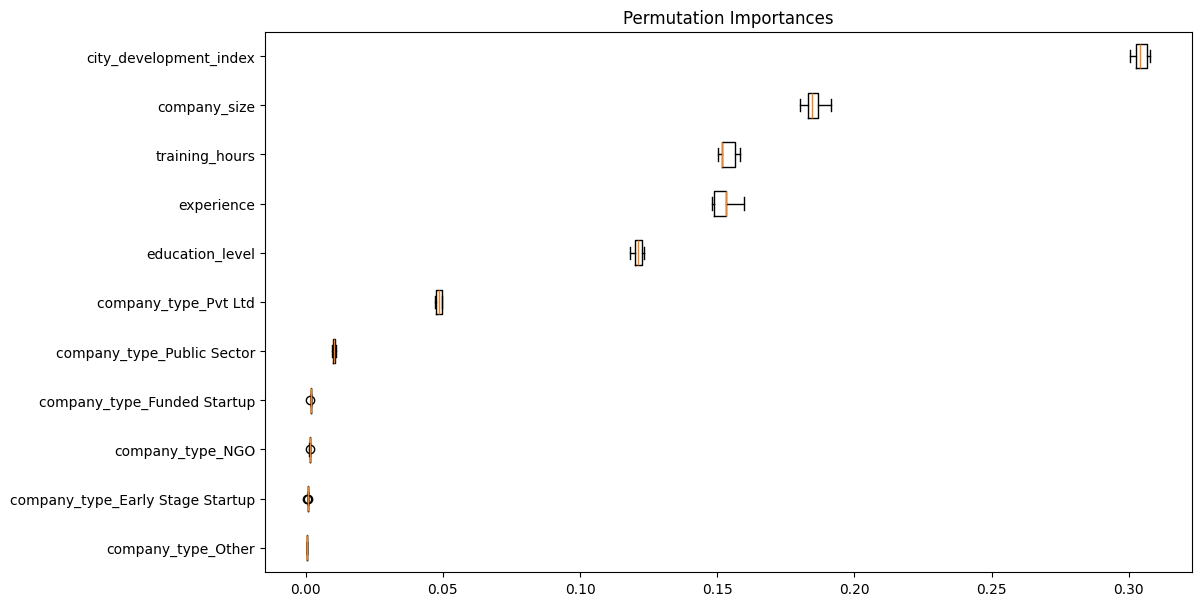

In [31]:
visualize_feature_importance(feature_importances)

In [34]:
n_repeats = 10

In [35]:
feature_importances = permutation_importance(
    estimator=random_forest_classifier,
    X=X_train,
    y=y_train,
    n_repeats=n_repeats,
    random_state=random_state,
    n_jobs=n_jobs
)

/tmp/ipykernel_5426/3876120176.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(importance_array.importances[sorted_idx].T,


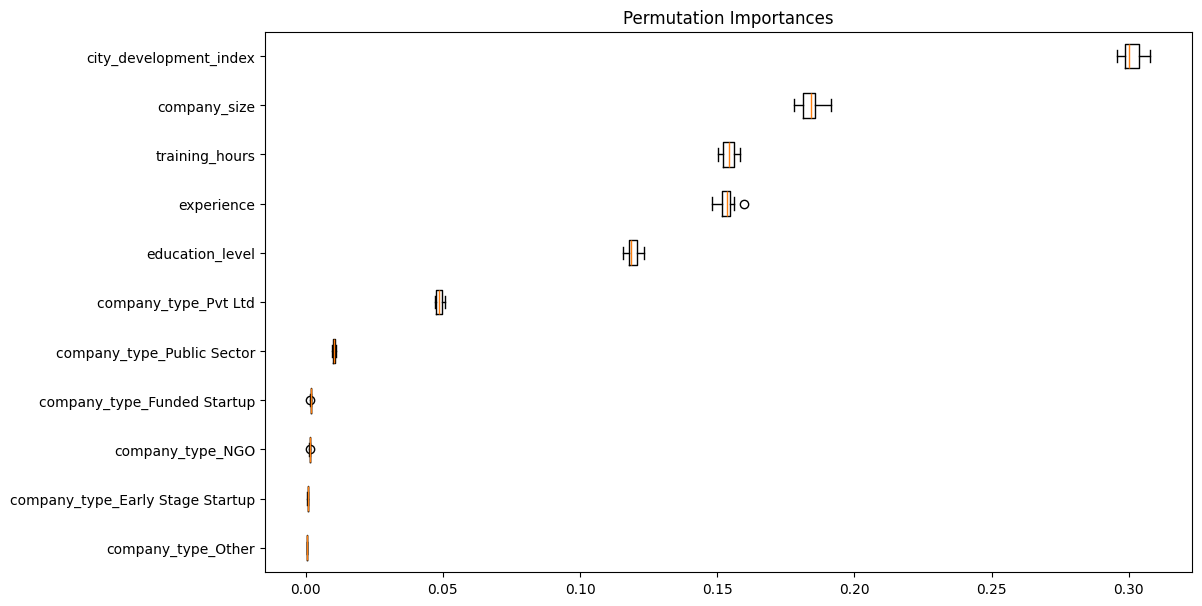

In [37]:
visualize_feature_importance(feature_importances)

## Partial Dependency Plot

Partial Dependency Plot (PDP) is an effective way to illustrate the relationship between an interested feature and the model outcome. It essentially visualizes the marginal effects of a feature, that is, shows how the model outcome changes when a specific feature changes in its distribution.

Since a machine learning model may include many features, and it is not feasible to create PDP for every single feature. Thus, we normally first find the most important features via ranking their feature importances. Then, we can only focus PDP on those important features.

From the previous step, we know some important features are `city_development_index`, `company_size`, `experience`, `education_level`, and we can easily create PDP for those features using `plot_partial_dependence` in `sklearn` package.

In [41]:
important_features = ['city_development_index', 'experience']

In [46]:
partial_dependence = partial_dependence(
    estimator=random_forest_classifier,
    X=X,
    features=important_features,
    percentiles=(0, 1)
)

KeyboardInterrupt: 

In [ ]:
dependence_display = PartialDependenceDisplay(
    [partial_dependence],
    features=X[important_features].index,
    feature_names=important_features
)

## Global Surrogate Model

Now you have explored how to explain the black-box model via analyzing its features. Next, we will learn how to explain it via approximate of their inputs and outputs with a global surrogate model.

We will be training two self-interpretable models: 1) a logistic regression model and 2) a decision tree models using the inputs and outputs from the black-box model

You can follow these general steps to build a global surrogate model:

- First, we select a dataset `X_test` as input

- Then, we use the black-box model to make predictions `y_blackbox` using the `X_test`

- With both training data and labels ready, we can use them to train a simple logistic regression model and a decision tree model

- The surrogate model outputs its own predictions `y_surrogate`

- Lastly, we can measure the difference between `y_surrogate` and `y_blackbox` using an accuracy score to determine how well the surrogate model approximating the black-box model

